In [27]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [28]:
root_dir = r"C:\Users\risuser\Documents\RISET_FATHAN\dataset"

normal_ids = [1003, 1005, 1032, 1051, 1062, 1063, 1066, 1067, 1072, 1078,
              1080, 1083, 1101, 1116, 1117, 1119, 1127, 1128, 1143, 1144]
sianotik_ids = [1008, 1010, 1012, 1015, 1028, 1037, 1046, 1050, 1064, 1074,
                1085, 1092, 1099, 1105, 1111, 1113, 1120, 1125, 1129, 1141,
                1145, 1146, 1147, 1150, 1158, 1178]
non_sianotik_ids = [1001, 1002, 1007, 1011, 1014, 1018, 1019, 1020, 1025, 1029,
                    1033, 1035, 1036, 1041, 1047, 1061, 1070, 1079, 1103, 1109,
                    1132, 1133, 1135, 1139, 1140, 1148]

patient_to_label = {}
for pid in sianotik_ids:
    patient_to_label[str(pid)] = 0  # Sianotik
for pid in non_sianotik_ids:
    patient_to_label[str(pid)] = 1  # Non-Sianotik
for pid in normal_ids:
    patient_to_label[str(pid)] = 2  # Normal

class CTScanDataset(Dataset):
    def __init__(self, patient_dirs, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform

        for patient_dir in patient_dirs:
            patient_id = patient_dir.split("_")[-1]
            label = patient_to_label[patient_id]

            full_patient_dir = os.path.join(root_dir, patient_dir)
            for img_file in os.listdir(full_patient_dir):
                if img_file.endswith('.png'):
                    img_path = os.path.join(full_patient_dir, img_file)
                    self.image_paths.append(img_path)
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L') 
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

transform = transforms.Compose([
    transforms.Resize((128, 128)),       # Resize untuk konsistensi dimensi
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [29]:
random.seed(42)

def split_specific(patient_ids, n_train, n_val, n_test):
    random.shuffle(patient_ids)
    train_ids = patient_ids[:n_train]
    val_ids = patient_ids[n_train:n_train+n_val]
    test_ids = patient_ids[n_train+n_val:n_train+n_val+n_test]
    return train_ids, val_ids, test_ids

normal_train, normal_val, normal_test = split_specific(normal_ids, n_train=16, n_val=2, n_test=2)
sianotik_train, sianotik_val, sianotik_test = split_specific(sianotik_ids, n_train=20, n_val=3, n_test=3)
non_sianotik_train, non_sianotik_val, non_sianotik_test = split_specific(non_sianotik_ids, n_train=20, n_val=3, n_test=3)

train_patients = normal_train + sianotik_train + non_sianotik_train
val_patients = normal_val + sianotik_val + non_sianotik_val
test_patients = normal_test + sianotik_test + non_sianotik_test

train_patients_dirs = [f'ct_{pid}' for pid in train_patients]
val_patients_dirs = [f'ct_{pid}' for pid in val_patients]
test_patients_dirs = [f'ct_{pid}' for pid in test_patients]

print(f"Train Patients: {len(train_patients_dirs)} | Val Patients: {len(val_patients_dirs)} | Test Patients: {len(test_patients_dirs)}")

batch_size = 32

train_dataset = CTScanDataset(train_patients_dirs, transform=transform)
val_dataset = CTScanDataset(val_patients_dirs, transform=transform)
test_dataset = CTScanDataset(test_patients_dirs, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Train Patients: 56 | Val Patients: 8 | Test Patients: 8


In [30]:
class EnhancedCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3),
            
            # Block 2
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4),
            
            # Block 3
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.5)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 16 * 16, 256),
            nn.Dropout(0.6),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(128, 3)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

model = EnhancedCNN().to(device)


Epoch [1/50]
Train Loss: 1.1068 | Train Acc: 0.3645
Val Loss: 1.0975 | Val Acc: 0.3723
Learning Rate: 0.000050

Epoch [2/50]
Train Loss: 1.0796 | Train Acc: 0.4043
Val Loss: 1.0927 | Val Acc: 0.3450
Learning Rate: 0.000050

Epoch [3/50]
Train Loss: 1.0423 | Train Acc: 0.4594
Val Loss: 1.0823 | Val Acc: 0.3145
Learning Rate: 0.000050

Epoch [4/50]
Train Loss: 0.9861 | Train Acc: 0.5154
Val Loss: 1.0970 | Val Acc: 0.3186
Learning Rate: 0.000050

Epoch [5/50]
Train Loss: 0.9192 | Train Acc: 0.5616
Val Loss: 1.0632 | Val Acc: 0.4532
Learning Rate: 0.000050

Epoch [6/50]
Train Loss: 0.8439 | Train Acc: 0.6097
Val Loss: 1.0948 | Val Acc: 0.4718
Learning Rate: 0.000050

Epoch [7/50]
Train Loss: 0.7887 | Train Acc: 0.6477
Val Loss: 1.1166 | Val Acc: 0.4709
Learning Rate: 0.000050

Epoch [8/50]
Train Loss: 0.7401 | Train Acc: 0.6682
Val Loss: 1.1243 | Val Acc: 0.4577
Learning Rate: 0.000050

Epoch [9/50]
Train Loss: 0.6960 | Train Acc: 0.6866
Val Loss: 1.2095 | Val Acc: 0.4345
Learning Rate: 0.

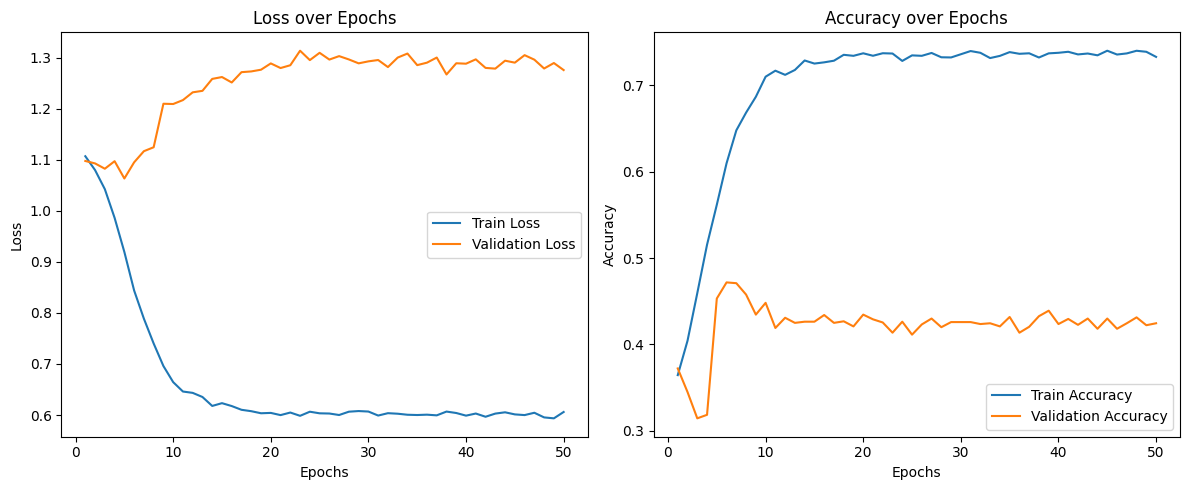

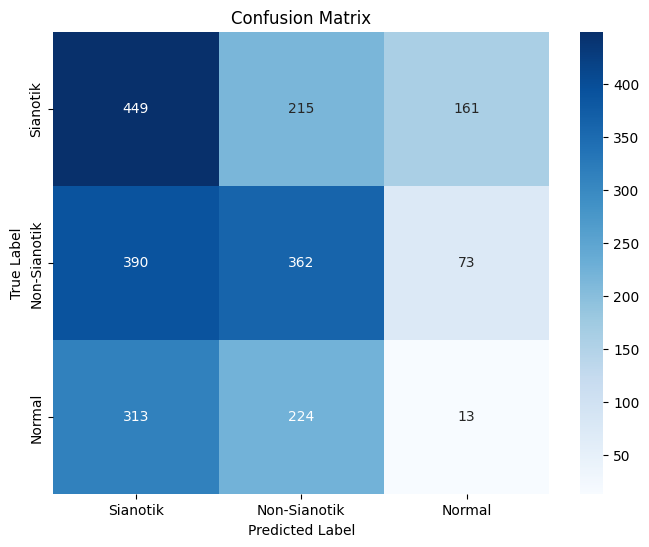

Classification Report:
              precision    recall  f1-score   support

    Sianotik       0.39      0.54      0.45       825
Non-Sianotik       0.45      0.44      0.45       825
      Normal       0.05      0.02      0.03       550

    accuracy                           0.37      2200
   macro avg       0.30      0.34      0.31      2200
weighted avg       0.33      0.37      0.35      2200

Test Accuracy: 0.3745


In [31]:
train_labels = [label for _, label in CTScanDataset(train_patients_dirs)]
class_counts = np.bincount(train_labels)
class_weights = torch.tensor(1.0 / (class_counts / class_counts.max()), 
                            dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer 
optimizer = optim.AdamW(model.parameters(), 
                       lr=0.00005,  
                       weight_decay=1e-4)  

# Scheduler 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',
    patience=3,  
    factor=0.3,  
    verbose=True
)

num_epochs = 50
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_loss = float('inf')  # Tetap pertahankan untuk menyimpan model terbaik

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_preds += (preds == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct_preds / len(train_dataset)

    # Logika validasi tetap sama
    model.eval()
    val_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = val_correct / len(val_dataset)
    
    # Simpan model terbaik tanpa early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    # Update scheduler
    scheduler.step(val_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}\n")

epochs = range(1, len(train_losses) + 1)  # Pakai panjang data aktual

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Sianotik', 'Non-Sianotik', 'Normal'], 
            yticklabels=['Sianotik', 'Non-Sianotik', 'Normal'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Sianotik', 'Non-Sianotik', 'Normal']))

test_accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {test_accuracy:.4f}")